<a href="https://colab.research.google.com/github/mikeguzman1294/DPP4GA4SRMP4MCDA/blob/kendall-tau/KendallTau_DPP_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Kendall Tau + DPP Sampling Experimentation

##Import Libraries

Libraries already used in main script v1.0 (leanSRMP.py)

In [60]:
# Imports taken directly from professors' main script

import numpy
import scipy.sparse as sparse
import matplotlib.pyplot as pyplot
import argparse
import json
import ast
import sys
import os
import cProfile
from random import randint

Libraries required for Kendall Tau + DPP experimentation

In [61]:
# Required libraries for Kendall Tau alternative

import functools # For creaing a user-defined comparison operator
import time # For assessing performance
from scipy import stats # For Kendall Tau
from sklearn.manifold import MDS # For MDS to visualize proximities
import subprocess # For importing missing libraries real-time

Install/import pydpp by any means

In [62]:
try:
  from pydpp.dpp import DPP # Implements DPP
except:
  try:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'pydpp'])
    from pydpp.dpp import DPP
  except:
    subprocess.check_call(['git' ,'clone', 'https://github.com/satwik77/pyDPP.git'])
    subprocess.check_call(['%cd', 'pyDPP'])
    from pydpp.dpp import DPP

##Function Definitions

###Main Script Functions
Required functions directly extracted from main script v1.0.

Functions to create a random decision maker

In [63]:
def create_blank_decision_maker () :

    ###########################################################################################################
    """
        Creates a blank decision maker.
        --
        In:
            * None.
        Out:
            * decision_maker: Created decision maker, formatted as a dictionary, with only ID set.
    """
    ###########################################################################################################

    # We add a unique id to the decision maker
    global decision_maker_ids_counter
    if "decision_maker_ids_counter" not in globals() :
        decision_maker_ids_counter = 0
    else :
        decision_maker_ids_counter += 1

    # Let's create the object
    decision_maker = {"weights": None,
                      "profiles": None,
                      "order": None,
                      "id": decision_maker_ids_counter}
    
    # Done
    return decision_maker

In [64]:
def correct_decision_maker (decision_maker) :

    ###########################################################################################################
    """
        Corrects a decision maker.
        --
        In:
            * decision_maker: Decision maker to correct.
        Out:
            * None.
    """
    ###########################################################################################################

    # Profiles in [0, 1] and sorted
    decision_maker["profiles"][decision_maker["profiles"] < 0.0] = 0.0
    decision_maker["profiles"][decision_maker["profiles"] > 1.0] = 1.0
    decision_maker["profiles"] = -numpy.sort(-decision_maker["profiles"], axis=0)
    
    # Weights in ]0, 1] and with 1-sum
    nb_criteria = decision_maker["profiles"].shape[1]
    decision_maker["weights"][decision_maker["weights"] < 0.0] = 1.0 / nb_criteria
    decision_maker["weights"][decision_maker["weights"] > 1.0] = 1.0
    decision_maker["weights"] /= numpy.sum(decision_maker["weights"])

In [65]:
def create_random_decision_maker (nb_criteria, nb_profiles) :

    ###########################################################################################################
    """
        Creates a random decision maker.
        --
        In:
            * nb_criteria: Number of criteria.
            * nb_profiles: Number of profiles to generate.
        Out:
            * decision_maker: Randomly created decision maker, formatted as a dictionary.
    """
    ###########################################################################################################

    # Random weights and profiles
    decision_maker = create_blank_decision_maker()
    decision_maker["weights"] = numpy.random.rand(nb_criteria)
    decision_maker["profiles"] = numpy.random.uniform(0.0, 1.0, (nb_profiles, nb_criteria))
    correct_decision_maker(decision_maker)
    
    # We choose an order for the profiles
    order = numpy.array(range(nb_profiles))
    numpy.random.shuffle(order)
    decision_maker["order"] = order

    # Done
    return decision_maker

Functions for plotting a decision maker

In [66]:
def create_directory_for (file_name) :

    ###########################################################################################################
    """
        Creates the directory for the given file name if it does not exist.
        --
        In:
            * file_name: Directory to create, or file for which we want to create a directory.
        Out:
            * None.
    """
    ###########################################################################################################

    # Creates the corresponding directory
    dir_name = os.path.dirname(file_name)
    os.makedirs(dir_name, exist_ok=True)

In [67]:
def plot_decision_maker (decision_maker, alternatives=[], title="", file_name=None) :

    ###########################################################################################################
    """
        Plots a decision maker.
        --
        In:
            * decision_maker: Decision maker to plot.
            * alternatives: List of alternatives to plot with the decision maker.
            * title: Complementary information to plot in the title.
            * file_name: Where to save the results.
        Out:
            * None.
    """
    ###########################################################################################################

    # Vertical bars
    figure = pyplot.figure(figsize=(20, 10))
    nb_criteria = decision_maker["profiles"].shape[1]
    for i in range(nb_criteria) :
        pyplot.plot([i, i], [0, 1], "k")

    # Profiles
    nb_profiles = decision_maker["profiles"].shape[0]
    for i in range(nb_profiles) :
        plotted = pyplot.plot(range(nb_criteria), decision_maker["profiles"][i], ":*")
        pyplot.text(-0.02 * nb_criteria, decision_maker["profiles"][i][0], "p" + str(i), color=plotted[-1].get_color())
        pyplot.text(nb_criteria - 1 + 0.01 * nb_criteria, decision_maker["profiles"][i][-1], "p" + str(i), color=plotted[-1].get_color())
    
    # Alternatives
    for alternative in alternatives :
        plotted = pyplot.plot(range(nb_criteria), alternative["profile"], "-*", label=alternative["id"])
        pyplot.text(-0.02 * nb_criteria, alternative["profile"][0], "a" + str(alternative["id"]), color=plotted[-1].get_color())
        pyplot.text(nb_criteria - 1 + 0.01 * nb_criteria, alternative["profile"][-1], "a" + str(alternative["id"]), color=plotted[-1].get_color())
    
    # Plot decorations
    pyplot.xticks(range(nb_criteria), ["w" + str(i) + " =\n" + str(decision_maker["weights"][i]) for i in range(nb_criteria)], rotation=45)
    pyplot.yticks([0, 1])
    figure.gca().set_frame_on(False)
    pyplot.tight_layout()
    pyplot.title("dm" + str(decision_maker["id"]) + "\n" + " -> ".join("p" + str(o) for o in decision_maker["order"]) + ("\n" + title if title != "" else ""))
    pyplot.show()
    
    # Save
    if file_name is not None :
        create_directory_for(file_name)
        figure.savefig(file_name, bbox_inches="tight")

Function to generate a population

In [68]:
def generate_initial_population (population_size, nb_profiles, nb_criteria) :

    ###########################################################################################################
    """
        Generates a population of initial solution.
        --
        In:
            * population_size: Number of random solutions to produce.
            * nb_profiles: Number of profiles to give to random solutions.
            * expected_results: Provided comparisons, along with their preference relation.
        Out:
            * population: List of created decision makers, along with their fitnesses.
    """
    ###########################################################################################################

    # We generate random solutions independently
    #nb_criteria = len(expected_results[0][0]["profile"])
    population = [create_random_decision_maker(nb_criteria, nb_profiles) for i in range(population_size)]
    
    # We sort them in decreasing fitness
    #population = [(compute_fitness(solution, expected_results), solution) for solution in population]
    population = [(numpy.random.uniform(0.0, 1.0), solution) for solution in population]
    population = sorted(population, key=lambda obj : -obj[0])
    
    # Done
    return population

Function to create a random alternative

In [69]:
def create_random_alternative (nb_criteria) :

    ###########################################################################################################
    """
        Creates a random alternative.
        --
        In:
            * nb_criteria: Number of criteria.
        Out:
            * alternative: Created alternative, formatted as a dictionary.
    """
    ###########################################################################################################

    # An alternative is a profile
    profile = numpy.random.uniform(0.0, 1.0, nb_criteria)

    # We add a unique id to the alternative
    global alternative_ids_counter
    if "alternative_ids_counter" not in globals() :
        alternative_ids_counter = 0
    else :
        alternative_ids_counter += 1

    # Let's create the alternative
    alternative = {"profile": profile,
                   "id": alternative_ids_counter}

    # Done
    return alternative

Functions used to compute preferences between alternatives for a given decision maker

In [70]:
def compute_concordance (decision_maker, discriminating_profile, alternative) :

    ###########################################################################################################
    """
        Returns the concordance of an alternative with respect to a reference profile.
        --
        In:
            * decision_maker: Reference decision maker used to compute concordance of the alternative.
            * discriminating_profile: Number of the profile to use in the decision maker's profiles.
            * alternative: Alternative for which we want to compute concordance.
        Out:
            * result: Concordance for the alternative.
    """
    ###########################################################################################################

    # Sum of weights for all criteria above discriminating profile
    result = numpy.dot(alternative["profile"] >= decision_maker["profiles"][discriminating_profile], decision_maker["weights"].transpose())
    
    # Done
    return result

In [71]:
def check_preference (decision_maker, alternative_1, alternative_2) :

    ###########################################################################################################
    """
        Check which is preferred between two alternatives according to given decision maker.
        --
        In:
            * decision_maker: Reference decision maker used to compare alternatives.
            * alternative_1: First alternative to compare.
            * alternative_2: Second alternative to compare.
        Out:
            * preferred: Alternative in {alternative_1, alternative_2} which is preferred, or None if there is no preference.
            * discriminating_profile: Profile used in the decision maker to determine preference, or None if there is no preference.
    """
    ###########################################################################################################

    # Default value if no alternative is preferred to the other
    preferred, discriminating_profile = None, None
    
    # We check preferred profiles in the given order
    for i in decision_maker["order"] :
        alternative_1_concordance = compute_concordance(decision_maker, i, alternative_1)
        alternative_2_concordance = compute_concordance(decision_maker, i, alternative_2)
        if alternative_1_concordance > alternative_2_concordance :
            return alternative_1, i
        elif alternative_1_concordance < alternative_2_concordance :
            return alternative_2, i
    
    # Done
    return preferred, discriminating_profile

In [72]:
def compute_all_preferences (decision_maker, alternatives) :

    ###########################################################################################################
    """
        Checks all preference relations among alternatives according to given decision maker.
        --
        In:
            * decision_maker: Reference decision maker used to compare alternatives.
            * alternatives: List of alternatives to compare.
        Out:
            * discriminating_profiles: Matrix (sorted in increasing IDs) of profiles used in the decision maker to determine dominance, with -1 entries if there is no dominance.
            * preferences: Matrix (sorted in increasing IDs) of dominances, where result_dominances[i][j] == 1 if alternative i dominates alternative j, -1 if there is no dominance, and 0 otherwise.
    """
    ###########################################################################################################
    
    # Alternatives are sorted in increasing ID for the matrix
    sorted_alternatives = sorted(alternatives, key=lambda obj : obj["id"])
    nb_alternatives = len(sorted_alternatives)
    
    # We return a matrix indicating which profile is used for determining preference, and another indicating which alternative is preferred
    discriminating_profiles = numpy.zeros((nb_alternatives, nb_alternatives)) - 1
    preferences = numpy.zeros((nb_alternatives, nb_alternatives)) - 1
    
    # We check all pairs
    for alternative_1 in range(nb_alternatives) :
        for alternative_2 in range(alternative_1 + 1, nb_alternatives) :
            preferred, discriminating_profile = check_preference(decision_maker, sorted_alternatives[alternative_1], sorted_alternatives[alternative_2])
            if preferred is not None :
                discriminating_profiles[alternative_1, alternative_2] = discriminating_profile
                discriminating_profiles[alternative_2, alternative_1] = discriminating_profiles[alternative_1, alternative_2]
                preferences[alternative_1, alternative_2] = int(preferred["id"] == alternatives[alternative_1]["id"])
                preferences[alternative_2, alternative_1] = 1 - preferences[alternative_1, alternative_2]
    
    # Done
    return discriminating_profiles, preferences

###DPP + Kendall Tau Functions
Functions defined to implement DPP + Kendall Tau sampling in the genetic algorithm.

Ranks all alternatives according for a given decision maker.

In [73]:
def rank_decision_maker_alternatives (decision_maker, alternatives) :

    ###########################################################################################################
    """
        Ranks all alternatives according to given decision maker.
        --
        In:
            * decision_maker: Reference decision maker used to rank alternatives.
            * alternatives: List of alternatives to rank.
        Out:
            * ranking_vector: Vector containing the alternatives ranking for a given position maker where the first element is the best ranked alternative.
    """
    ###########################################################################################################

    # Inner user-defined comparison operator
    def compare(alternative_1, alternative_2):

      # No preference among alternatives
      if ( check_preference(decision_maker, alternative_1, alternative_2)[0] is None ):
        return 0
      # Alternative 1 > alternative 2
      elif ( alternative_1['id'] == check_preference(decision_maker, alternative_1, alternative_2)[0]['id'] ):
        return 1
      # Alternative 2 > alternative 1
      else:
        return -1

    # Sort (O(nlogn)) with user-defined comparison operator
    ranked_alternatives = sorted(alternatives, key=functools.cmp_to_key(compare))
    
    # Extract vector with only ranked alternatives
    ranking_vector = [ alternative['id'] for alternative in ranked_alternatives ]

    #Done
    return ranking_vector

Computes the ranking of all the alternatives for every solution in the population.

In [74]:
def compute_population_rankings (population, alternatives) :

    ###########################################################################################################
    """
        Computes the ranking of all the alternatives for every solution in the population.
        --
        In:
            * population: Population of solutions of a given generation along with their fitnesses.
            * alternatives: List of alternatives to rank.
        Out:
            * population_rankings: List of ranked alternatives vectors for all solutions.
    """
    ###########################################################################################################
    
    # Create empty list of rankings
    population_rankings = []

    # Append the ranking vector of each decision maker in population
    for solution in population:    
      population_rankings.append( rank_decision_maker_alternatives(solution[1], alternatives) )

    # Done
    return population_rankings

Constructs a similarity matrix for the population where the similarity metric is Kendall Tau correspondance between rankings.

In [75]:
def compute_similarity_matrix (rankings) :

    ###########################################################################################################
    """
        Constructs a similarity matrix for the population where the similarity metric is Kendall Tau correspondance between rankings.
        --
        In:
            * rankings: List of ranked alternatives vectors for all solutions.
        Out:
            * similarity_matrix: Matrix containing the pairwise Kendall Tau correspondance of all solutions' rankings.
    """
    ###########################################################################################################

    # Compute similarity matrix of all decision makers Kendall Tau's pairwise evaluation
    similarity_matrix = numpy.array( [ [ ( (stats.kendalltau(p1, p2)[0] + 1) / 2  ) for p2 in rankings ] for p1 in rankings ] )

    #Done
    return similarity_matrix

This one is not really a new function but an **update** to a function that previously only implemented a roulette parent selection strategy.

In [76]:
def select_solutions (population, alternatives, nb_solutions=None, strategy=None) :

    ###########################################################################################################
    """
        Selects solutions to mix from the population.
        --
        In:
            * population: Population of solutions from where to pick solutions, along with their fitnesses.
            * alternatives: List of alternatives to compare.
            * nb_solutions: Number of solutions to return.
            * strategy: Strategy to use to select solutions.
        Out:
            * selected_solutions: Picked solutions.
    """
    ###########################################################################################################

    # Retrieve command line default arguments
    #nb_solutions = get_arg_value("select_solutions__nb_solutions", nb_solutions)
    #strategy = get_arg_value("select_solutions__strategy", strategy)

    # Probabilities are based on fitness
    if strategy == "roulette" :
        probabilities = numpy.array([solution[0] for solution in population], dtype=float)
        probabilities /= numpy.sum(probabilities)
        selected_indices = numpy.random.choice(range(len(population)), nb_solutions, p=probabilities, replace=False)
        selected_solutions = [population[i] for i in selected_indices]

    # Use a Kendall Tau based similarity matrix of all decision makers as a DPP kernel
    elif strategy == "kendall-tau" :
        rankings = compute_population_rankings(population, alternatives)
        dpp = DPP(rankings)
        dpp.compute_kernel(kernel_func=compute_similarity_matrix)
        selected_indices = dpp.sample_k(nb_solutions)
        selected_solutions = [population[i] for i in selected_indices]

    # Weird choice
    else :
        raise Exception("Unimplemented strategy '" + strategy + "' for function 'select_solutions'")
    
    # Done
    return selected_solutions

## Test Section

###Global Test Parameters

In [77]:
# Global Hyper Parameters to test DPP + Kendall Tau functions on a decision maker individual/population in the test section

num_criteria = 5  # Number of criteria per decision maker
num_profiles = 3  # Number of profiles per decision maker
num_alternatives = 10  # Number of alternatives to test against individuals/population
population_size = 200 # Number of decision makers in the population
num_parents = 8 # Number of solutions to select as parents
strategy = "kendall-tau" # Parent selection strategy

###Understand/Visualize Genotype

In [78]:
# GENOTYPE

# Code cell to create a single random decision maker

decision_maker = create_random_decision_maker(num_criteria, num_profiles)
decision_maker

{'weights': array([0.12709338, 0.11427255, 0.35222368, 0.02954624, 0.37686415]),
 'profiles': array([[0.85974135, 0.62023648, 0.95160533, 0.74580793, 0.96290449],
        [0.40826303, 0.53634156, 0.87135583, 0.39415908, 0.63327832],
        [0.06953575, 0.4552669 , 0.45501736, 0.1027629 , 0.40071342]]),
 'order': array([0, 2, 1]),
 'id': 201}

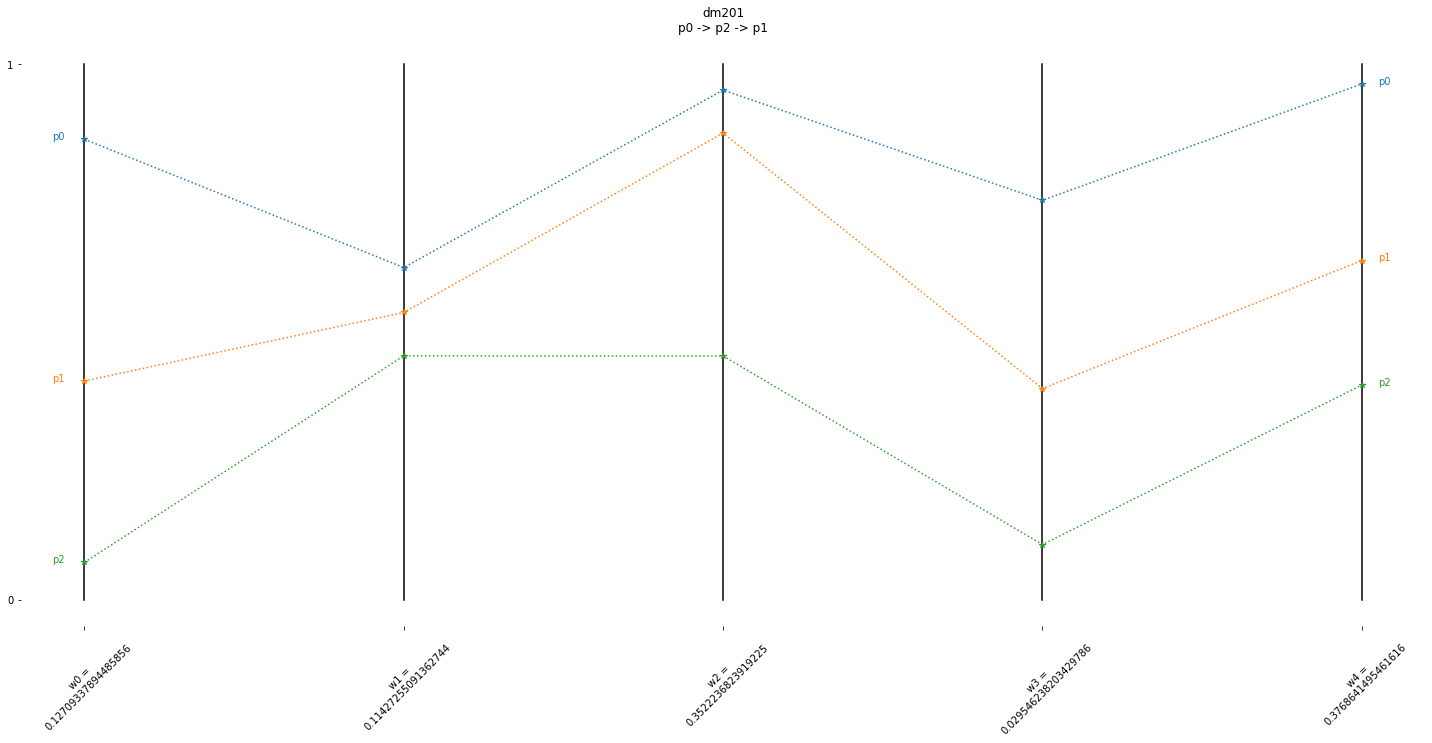

In [79]:
# PHENOTYPE

# Plot a decision maker individual

plot_decision_maker(decision_maker)

###Understand concordance

In [80]:
# Code cell to create a single random alternative

alternative = create_random_alternative(num_criteria)
alternative

{'profile': array([0.80159914, 0.58351784, 0.13929797, 0.5694075 , 0.40082987]),
 'id': 11}

In [81]:
# Choose a random discriminating profile index

discriminating_profile = randint(0, (num_profiles -1) )
print(f'Discriminating profile index: {discriminating_profile}')
print(f'Discriminating profile of decision maker individual: {decision_maker["profiles"][discriminating_profile]}')
print(f'Weights of decision maker individual: {decision_maker["weights"]}')

# Compute of a random alternative against the decision maker individual given a random discriminating profile

concordance = compute_concordance(decision_maker, discriminating_profile, alternative)
print(f'Concordance value: {concordance}')

Discriminating profile index: 2
Discriminating profile of decision maker individual: [0.06953575 0.4552669  0.45501736 0.1027629  0.40071342]
Weights of decision maker individual: [0.12709338 0.11427255 0.35222368 0.02954624 0.37686415]
Concordance value: 0.6477763176080773


###Create population/alternatives

In [82]:
# Create a list of random alternatives

alternatives = [create_random_alternative(num_criteria) for i in range(num_alternatives)]
alternatives

[{'profile': array([0.28461779, 0.30253096, 0.18203409, 0.37239564, 0.26012876]),
  'id': 12},
 {'profile': array([0.2064901 , 0.73905209, 0.50510408, 0.76587478, 0.44861321]),
  'id': 13},
 {'profile': array([0.4095224 , 0.35450901, 0.29070215, 0.92925885, 0.2562753 ]),
  'id': 14},
 {'profile': array([0.49187976, 0.74551493, 0.48595801, 0.1956974 , 0.97389096]),
  'id': 15},
 {'profile': array([0.6882581 , 0.47599069, 0.24779896, 0.47158022, 0.57247908]),
  'id': 16},
 {'profile': array([0.65143972, 0.98632281, 0.04823596, 0.56616181, 0.32631179]),
  'id': 17},
 {'profile': array([0.24407683, 0.00642151, 0.74238161, 0.13485393, 0.67929754]),
  'id': 18},
 {'profile': array([0.95749994, 0.12478386, 0.33745012, 0.23798923, 0.55600908]),
  'id': 19},
 {'profile': array([0.09768901, 0.14466661, 0.52585352, 0.03661352, 0.68855973]),
  'id': 20},
 {'profile': array([0.43917465, 0.43847955, 0.07541865, 0.98778745, 0.85489531]),
  'id': 21}]

In [83]:
# Code cell to create a population of decision makers

population = generate_initial_population(population_size, num_profiles, num_criteria)
population[0:5]

[(0.9994946711825601,
  {'weights': array([0.21402895, 0.31583239, 0.003516  , 0.30748841, 0.15913425]),
   'profiles': array([[0.71350226, 0.90113675, 0.81389358, 0.77844194, 0.42320044],
          [0.59886917, 0.46840119, 0.73750736, 0.25124037, 0.25333471],
          [0.28651294, 0.12262564, 0.17058032, 0.15118716, 0.01803303]]),
   'order': array([0, 1, 2]),
   'id': 358}),
 (0.9993212497594955,
  {'weights': array([0.31142803, 0.11055881, 0.27457034, 0.15959287, 0.14384995]),
   'profiles': array([[0.64736808, 0.80763994, 0.93036382, 0.79117881, 0.74795205],
          [0.31002209, 0.63220314, 0.72493585, 0.62771425, 0.64725045],
          [0.29660626, 0.57842691, 0.22247599, 0.07497207, 0.35423264]]),
   'order': array([1, 2, 0]),
   'id': 269}),
 (0.9983397689800737,
  {'weights': array([0.04187418, 0.09077501, 0.47654213, 0.22386059, 0.16694809]),
   'profiles': array([[0.73931672, 0.75341979, 0.99395442, 0.88037984, 0.77840305],
          [0.24750484, 0.69345278, 0.93504667, 0.

###Select parents function

In [84]:
# Select solutions as parents from the population and time the selecting process for benchmarking

start = time.time()

selected_solutions = select_solutions(population, alternatives, num_parents, strategy)

end = time.time()

print(f'The parent selection process for a population of {num_parents} individuals takes {end - start} seconds.\n')

#selected_solutions

The parent selection process for a population of 8 individuals takes 12.868455648422241 seconds.



###Kendall Tau + DPP examination

####Alternatives ranking vectors

In [85]:
# Rank all the alternatives for each decision maker in the population and save each vector
 
rankings = compute_population_rankings(population, alternatives)

# Print the first 5 rankings

rankings[0:5]

[[12, 20, 18, 15, 13, 16, 14, 17, 19, 21],
 [12, 20, 13, 16, 19, 18, 17, 14, 15, 21],
 [18, 20, 12, 16, 13, 19, 17, 15, 14, 21],
 [20, 12, 14, 16, 17, 13, 15, 21, 19, 18],
 [12, 17, 16, 21, 20, 18, 14, 19, 15, 13]]

####Similarity Matrix

In [86]:
# Get the similarity matrix of all the decision makers given their ranked alternatives vectors

similarity_matrix = compute_similarity_matrix(rankings)
similarity_matrix

array([[1.        , 0.62222222, 0.57777778, ..., 0.37777778, 0.2       ,
        0.82222222],
       [0.62222222, 1.        , 0.73333333, ..., 0.48888889, 0.44444444,
        0.62222222],
       [0.57777778, 0.73333333, 1.        , ..., 0.26666667, 0.48888889,
        0.53333333],
       ...,
       [0.37777778, 0.48888889, 0.26666667, ..., 1.        , 0.6       ,
        0.51111111],
       [0.2       , 0.44444444, 0.48888889, ..., 0.6       , 1.        ,
        0.28888889],
       [0.82222222, 0.62222222, 0.53333333, ..., 0.51111111, 0.28888889,
        1.        ]])

####DPP Sampling

In [87]:
# Create a DPP sampler instance

dpp = DPP(rankings)

# Use the Kendall Tau similarity matrix as kernel function

dpp.compute_kernel(kernel_func=compute_similarity_matrix)

# Verify dpp attribute 'A' is the similarity matrix

dpp.A

array([[1.        , 0.62222222, 0.57777778, ..., 0.37777778, 0.2       ,
        0.82222222],
       [0.62222222, 1.        , 0.73333333, ..., 0.48888889, 0.44444444,
        0.62222222],
       [0.57777778, 0.73333333, 1.        , ..., 0.26666667, 0.48888889,
        0.53333333],
       ...,
       [0.37777778, 0.48888889, 0.26666667, ..., 1.        , 0.6       ,
        0.51111111],
       [0.2       , 0.44444444, 0.48888889, ..., 0.6       , 1.        ,
        0.28888889],
       [0.82222222, 0.62222222, 0.53333333, ..., 0.51111111, 0.28888889,
        1.        ]])

In [88]:
# Sample for the given parameter of parents to select (get back indices)

dpp_samples = dpp.sample_k(num_parents)
dpp_samples

array([  7,  31, 135, 152, 165, 167, 176, 194])

####MDS dimensionality reduction

In [89]:
# MDS requires a distance matrix as an input
# Since our similarity matrix has only positive correlations we can turn it easily into a distance matrix

distance_matrix = 1- similarity_matrix
distance_matrix

array([[0.        , 0.37777778, 0.42222222, ..., 0.62222222, 0.8       ,
        0.17777778],
       [0.37777778, 0.        , 0.26666667, ..., 0.51111111, 0.55555556,
        0.37777778],
       [0.42222222, 0.26666667, 0.        , ..., 0.73333333, 0.51111111,
        0.46666667],
       ...,
       [0.62222222, 0.51111111, 0.73333333, ..., 0.        , 0.4       ,
        0.48888889],
       [0.8       , 0.55555556, 0.51111111, ..., 0.4       , 0.        ,
        0.71111111],
       [0.17777778, 0.37777778, 0.46666667, ..., 0.48888889, 0.71111111,
        0.        ]])

In [90]:
# Create a MDS object to receive the precomputed distance matrix

mds = MDS(dissimilarity='precomputed', random_state=0)

# Get the MDS embeddings

X_transform = mds.fit_transform(distance_matrix)
X_transform[0:5]

array([[-0.17625263, -0.30880332],
       [-0.11212912, -0.11667939],
       [-0.3353919 ,  0.0287466 ],
       [-0.06196363,  0.42211927],
       [ 0.36407197, -0.16060083]])

Text(0.5, 1.0, 'Decision Maker MDS Embedding Space')

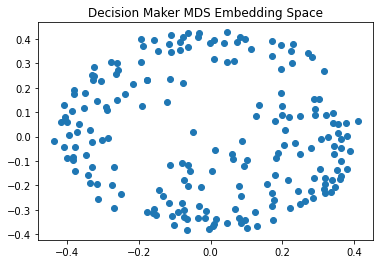

In [91]:
# Scatter plot the decision maker distance representation in the MDS 2-dim embedding space

pyplot.scatter( X_transform[:,0], X_transform[:,1] )
pyplot.title("Decision Maker MDS Embedding Space")

In [92]:
# Subset with the DPP-sampled indices 

X_DPP = X_transform[dpp_samples]
X_DPP

array([[-0.39455369,  0.0082227 ],
       [-0.38081603,  0.19198042],
       [ 0.19987637,  0.08722988],
       [-0.17811545,  0.22962976],
       [ 0.04575427,  0.42673009],
       [ 0.38058933, -0.13218722],
       [ 0.41096541,  0.06495783],
       [ 0.29139438,  0.08693056]])

####Plotting sample selections

#####DPP Samples Plot

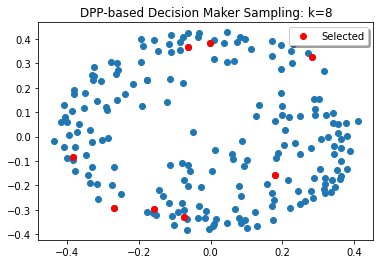

In [93]:
# Get some new DPP samples

dpp_samples = dpp.sample_k(num_parents)
X_DPP = X_transform[dpp_samples]

# Highlight the selected individuals in the MDS 2-dim embedding space

fig, ax = pyplot.subplots()
ax.plot(X_transform[:,0], X_transform[:,1], 'o', label='')
ax.plot(X_DPP[:,0], X_DPP[:,1], 'ro', label='Selected')
ax.set_title(f'DPP-based Decision Maker Sampling: k={num_parents}')
legend = ax.legend(loc='upper right', shadow=True, fontsize='medium')

#####DPP vs Random Plot
Compare DPP samples against randomly generated solution samples to evaluate DPP relevance.

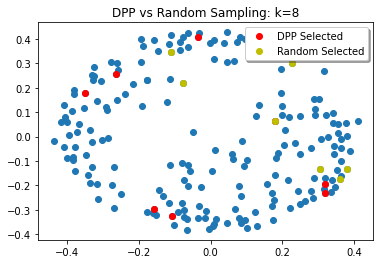

In [94]:
# Get some new DPP samples

dpp_samples = dpp.sample_k(num_parents)
X_DPP = X_transform[dpp_samples]

# Generate samples with randomly generated indices

random_samples = numpy.random.choice(range(population_size), num_parents, replace=False)
X_random = X_transform[random_samples]

# Highlight the selected individuals in the MDS 2-dim embedding space

fig, ax = pyplot.subplots()
ax.plot(X_transform[:,0], X_transform[:,1], 'o', label='')
ax.plot(X_DPP[:,0], X_DPP[:,1], 'ro', label='DPP Selected')
ax.plot(X_random[:,0], X_random[:,1], 'yo', label='Random Selected')
ax.set_title(f'DPP vs Random Sampling: k={num_parents}')
legend = ax.legend(loc='upper right', shadow=True, fontsize='medium')